<a href="https://colab.research.google.com/github/S-Delowar/TransferLearning_with_Tensorflow/blob/main/transfer_learning_tensorflow_FoodVissionMini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Apr 22 01:18:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Helper Functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-04-22 01:18:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-22 01:18:26 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# Working with Less Data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

--2025-04-22 01:18:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 142.251.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   234MB/s    in 7.2s    

2025-04-22 01:18:37 (215 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pho'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 75 image

In [7]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = "categorical",
    image_size = IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    shuffle = False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
len(train_data_all_10_percent.class_names)

101

## Create Model
- create a ModelCheckpoint callback
- data augmentation layer
- base_model (headless- no top layer)
- new model
- compile the model
- fit to extract features

In [9]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor="val_accuracy"
)

In [10]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomHeight, RandomWidth, RandomZoom, Rescaling
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2),
  RandomHeight(0.2),
  RandomWidth(0.2),
  RandomZoom(0.2),
  # Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [11]:
# setup base model
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False,
    input_shape = (224, 224, 3),
    weights = "imagenet"
)
# Freeze the base model
base_model.traiable = False

# Add new layers on Top
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) #Ensure inference mode
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 4,136,929 (15.78 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [13]:
# Compile
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit
history_all_classes_10_percent = model.fit(
    train_data_all_10_percent,
    epochs = 5,
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    callbacks = [checkpoint_callback]
)

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 152s 441ms/step - accuracy: 0.1744 - loss: 3.7479 - val_accuracy: 0.2545 - val_loss: 3.1422
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 141s 595ms/step - accuracy: 0.4730 - loss: 2.0957 - val_accuracy: 0.2993 - val_loss: 2.9155
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 142s 599ms/step - accuracy: 0.5770 - loss: 1.6039 - val_accuracy: 0.4266 - val_loss: 2.3068
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 141s 595ms/step - accuracy: 0.6373 - loss: 1.3077 - val_accuracy: 0.4261 - val_loss: 2.2466
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 142s 600ms/step - accuracy: 0.6915 - loss: 1.0858 - val_accuracy: 0.3618 - val_loss: 2.7372


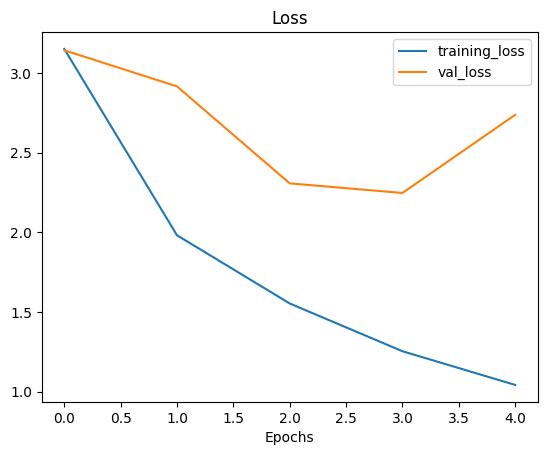

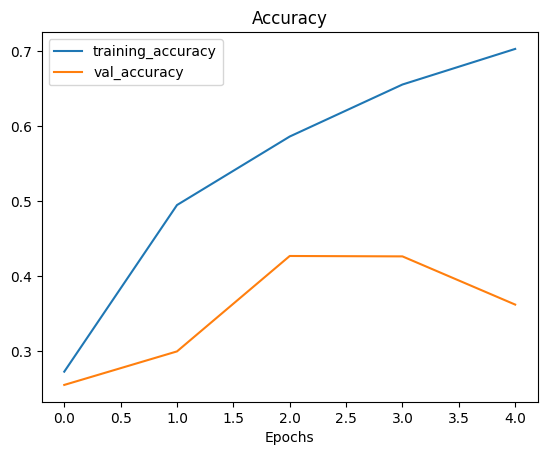

In [14]:
# Ploting the history of feature extractor model
plot_loss_curves(history_all_classes_10_percent)

In [15]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step - accuracy: 0.3812 - loss: 2.7004


[2.8222382068634033, 0.3665742576122284]

⏰The model is performing well on train data, not on test data. So, our model is overfitting.

Let's Fine-Tune the model...

In [16]:
# base_model.layers

## Fine-Tuning

In [17]:
# Unfreeze all tha layers of the model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
# Recompile the model with lower learning rate
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=["accuracy"]
)

In [19]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [20]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [21]:
fine_tune_epochs = 5

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)))

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.7567 - loss: 0.8699 - val_accuracy: 0.4341 - val_loss: 2.2840
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 146ms/step - accuracy: 0.8035 - loss: 0.7122 - val_accuracy: 0.4542 - val_loss: 2.1710
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step - accuracy: 0.8318 - loss: 0.6185 - val_accuracy: 0.4669 - val_loss: 2.1105
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.8314 - loss: 0.5993 - val_accuracy: 0.4701 - val_loss: 2.1013
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 34s 143ms/step - accuracy: 0.8540 - loss: 0.5294 - val_accuracy: 0.4725 - val_loss: 2.0902


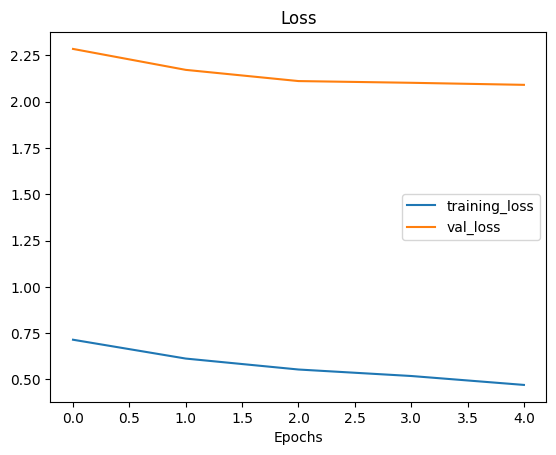

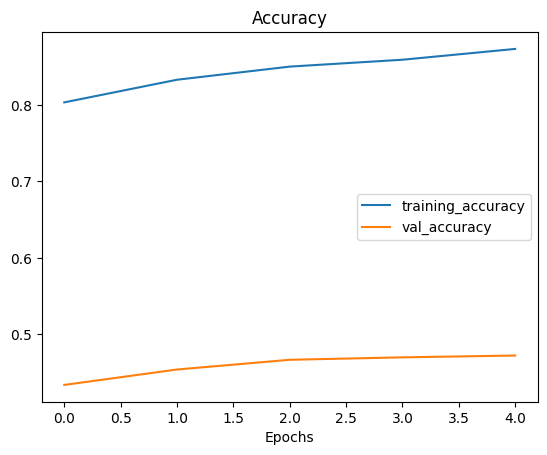

In [22]:
# Plot fine tune result history
plot_loss_curves(history_all_classes_10_percent_fine_tune)

In [23]:
import pandas as pd
pd.DataFrame(history_all_classes_10_percent_fine_tune.history)

accuracy      loss  val_accuracy  val_loss
0  0.803168  0.714584      0.434057  2.284042
1  0.832739  0.612888      0.454184  2.171026
2  0.849901  0.553816      0.466896  2.110533
3  0.858878  0.518795      0.470074  2.101255
4  0.873003  0.470652      0.472458  2.090171

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
model.save("drive/MyDrive/101_classes_10_percent_data_model_fine_tune.keras")

In [26]:
# Load the model
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_classes_10_percent_data_model_fine_tune.keras")

In [27]:
loaded_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 75ms/step - accuracy: 0.4916 - loss: 2.0347


[2.04899525642395, 0.4923960268497467]

## Make Prediction with our Trained Model

In [28]:
# Make Predictions
pred_probs = model.predict(test_data, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step


In [29]:
len(test_data)

790

In [30]:
len(pred_probs)

25250

In [31]:
25250/32

789.0625

In [32]:
pred_probs.shape

(25250, 101)

In [33]:
pred_probs[:10]

array([[9.42332000e-02, 1.07964850e-03, 4.45900299e-03, ...,
        7.07125946e-05, 2.90522526e-04, 3.84560379e-04],
       [1.54362069e-02, 7.57396920e-05, 1.17945276e-01, ...,
        4.54361131e-03, 4.21856763e-04, 1.52302033e-03],
       [2.86561430e-01, 8.29315046e-04, 8.12082738e-02, ...,
        2.30310671e-02, 1.37710385e-03, 1.84654829e-03],
       ...,
       [3.21751349e-02, 1.06229800e-05, 3.10224667e-03, ...,
        1.35559082e-01, 6.66935171e-04, 3.40034079e-04],
       [5.69142587e-02, 3.74503084e-04, 8.51762593e-01, ...,
        2.31469912e-03, 2.27592463e-04, 1.54006016e-03],
       [6.40038587e-03, 6.29792307e-09, 6.00153157e-07, ...,
        3.32824470e-08, 4.60992062e-08, 4.54290057e-05]], dtype=float32)

In [34]:
pred_probs[0].argmax()

np.int64(85)

In [35]:
test_data.class_names[85]

'samosa'

In [36]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:10]

array([85, 76,  8,  0,  2,  0, 98, 14,  2, 72])

In [37]:
len(test_data)

790

In [38]:
# Get our test labels we need to unreavel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  # print(labels.numpy().argmax())
  y_labels.append(labels.numpy().argmax())

In [39]:
len(y_labels)

25250

In [40]:
len(pred_classes)

25250

In [41]:
y_labels[:10]

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

In [42]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

## Evaluating our Model's Predictions

In [43]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [44]:
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.4923960396039604

In [45]:
# Confusion Matrix
cm = confusion_matrix(y_labels, pred_classes)
cm

array([[ 39,   0,  21, ...,  11,   0,   8],
       [  0, 118,   2, ...,   3,   2,   2],
       [  6,   0, 175, ...,   6,   1,   1],
       ...,
       [  1,   0,   7, ..., 118,   1,   0],
       [  1,   2,   2, ...,   0,  86,   0],
       [  3,   0,   2, ...,   4,   0, 142]])

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(100,100))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_names, yticklabels=test_data.class_names)


<Axes: >

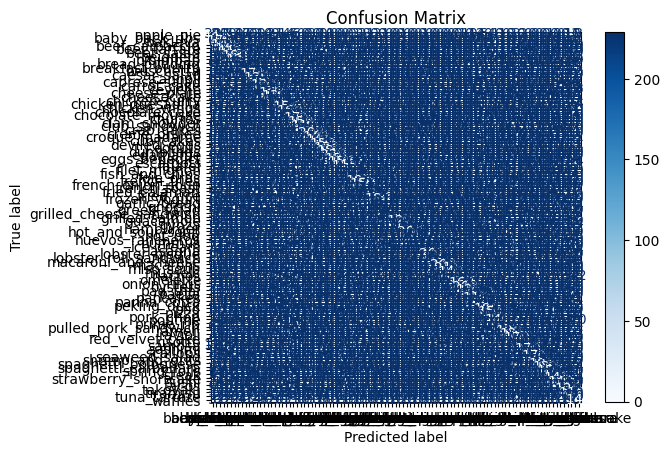

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [48]:
# Generate Classification Report
cr = classification_report(y_labels, pred_classes, output_dict=True)
print(cr)

{'0': {'precision': 0.1482889733840304, 'recall': 0.156, 'f1-score': 0.15204678362573099, 'support': 250.0}, '1': {'precision': 0.4896265560165975, 'recall': 0.472, 'f1-score': 0.48065173116089616, 'support': 250.0}, '2': {'precision': 0.3699788583509514, 'recall': 0.7, 'f1-score': 0.48409405255878285, 'support': 250.0}, '3': {'precision': 0.6190476190476191, 'recall': 0.572, 'f1-score': 0.5945945945945946, 'support': 250.0}, '4': {'precision': 0.39402173913043476, 'recall': 0.58, 'f1-score': 0.4692556634304207, 'support': 250.0}, '5': {'precision': 0.3168044077134986, 'recall': 0.46, 'f1-score': 0.37520391517128876, 'support': 250.0}, '6': {'precision': 0.35856573705179284, 'recall': 0.72, 'f1-score': 0.4787234042553192, 'support': 250.0}, '7': {'precision': 0.9699248120300752, 'recall': 0.516, 'f1-score': 0.6736292428198434, 'support': 250.0}, '8': {'precision': 0.2536873156342183, 'recall': 0.344, 'f1-score': 0.2920203735144312, 'support': 250.0}, '9': {'precision': 0.59016393442622

In [49]:
class_names = test_data.class_names
# class_names

In [50]:
# Create DataFrame with class names and their f1_score
class_f1_scores = {}
for k, v in cr.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

f1_scores = pd.DataFrame({
    "class_name": list(class_f1_scores.keys()),
    "f1_score": list(class_f1_scores.values())
}).sort_values("f1_score", ascending=False)

In [51]:
f1_scores.shape, f1_scores[:10]

((101, 2),
            class_name  f1_score
 33            edamame  0.950207
 54  hot_and_sour_soup  0.837398
 64          miso_soup  0.817829
 32          dumplings  0.813853
 69            oysters  0.790514
 75                pho  0.787629
 88      seaweed_salad  0.758315
 68        onion_rings  0.738041
 45      frozen_yogurt  0.732943
 63           macarons  0.731261)

<ipython-input-52-e309fd727243>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='f1_score', y='class_name', data=f1_scores, palette='viridis')


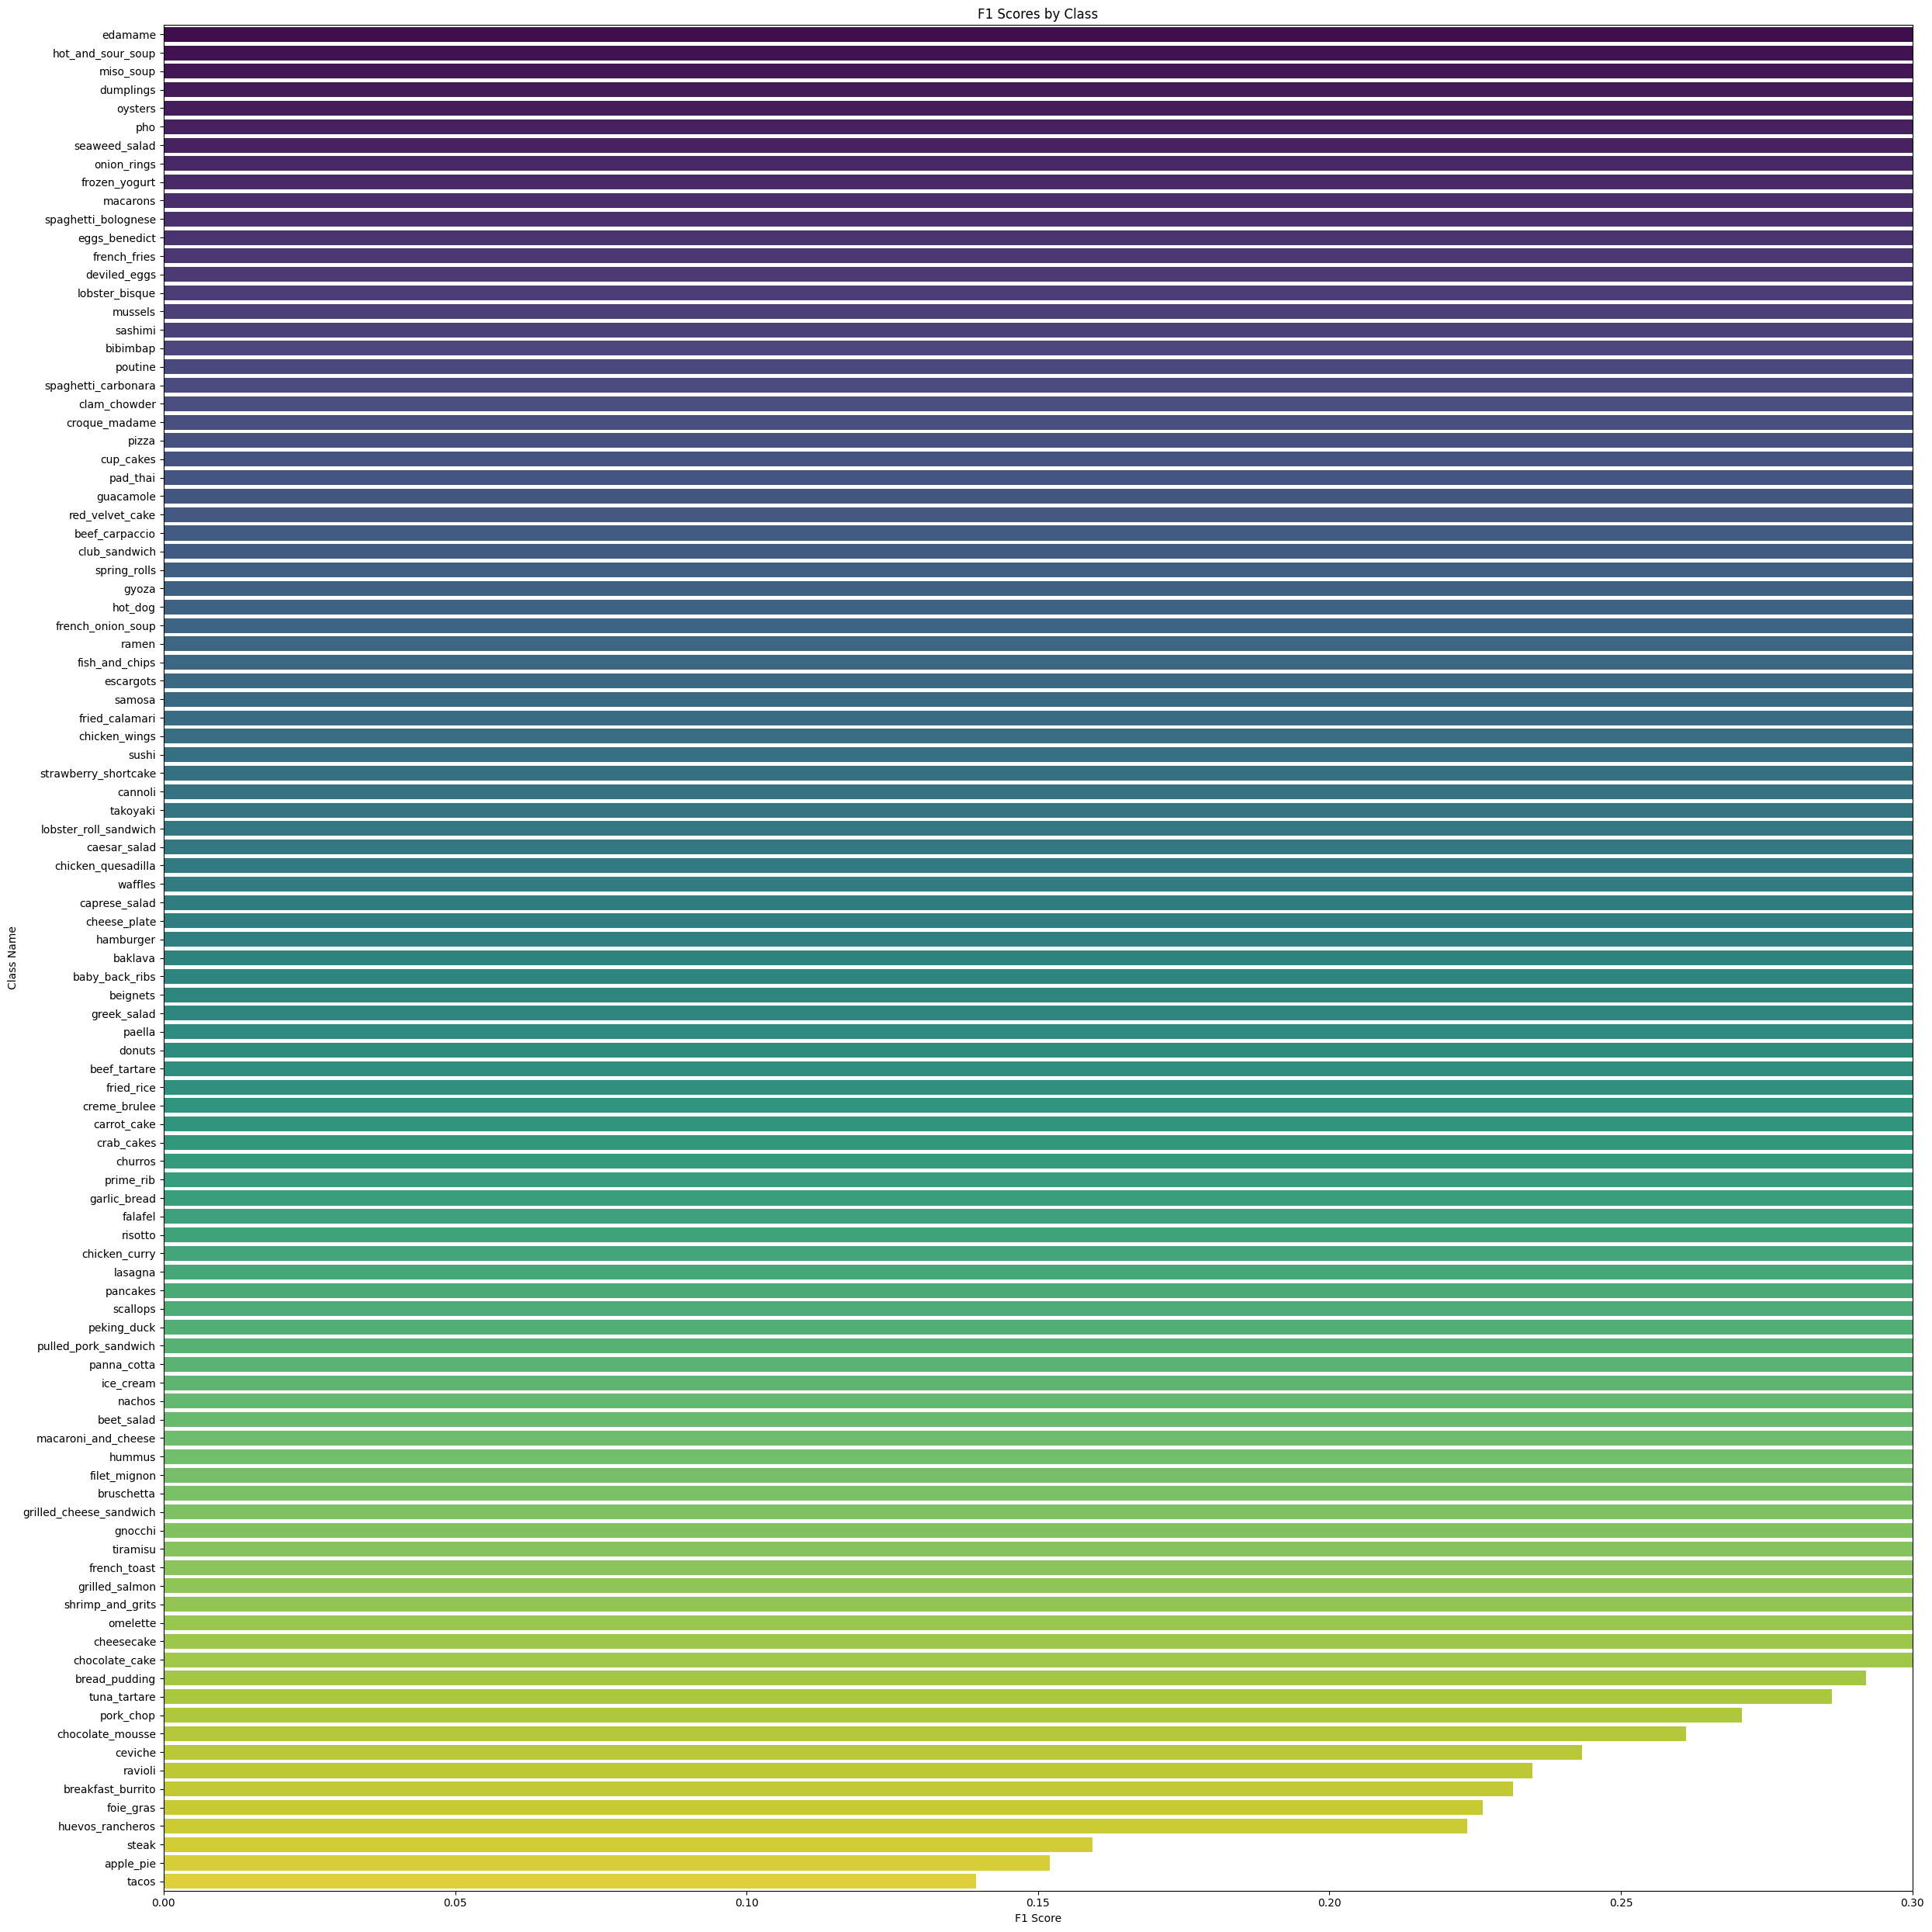

In [52]:
# Visualize the f1_score values
# Plot
plt.figure(figsize=(25, 25))
sns.barplot(x='f1_score', y='class_name', data=f1_scores, palette='viridis')
plt.xlabel('F1 Score')
plt.ylabel('Class Name')
plt.title('F1 Scores by Class')
plt.xlim(0, 0.3)  # Optional: to highlight low scores
plt.tight_layout()
plt.show()

## Visualizing predictions on test images

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:

Read in a target image filepath using tf.io.read_file()
Turn the image into a Tensor using tf.io.decode_image()
Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [53]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename=filename)
  # Decode the image into tensor
  img = tf.io.decode_image(img, channels=3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scaling
  if scale:
    return img/255.  # between 0 and 1
  else:
    return img

### Visualize some test images, their target label and our model's predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


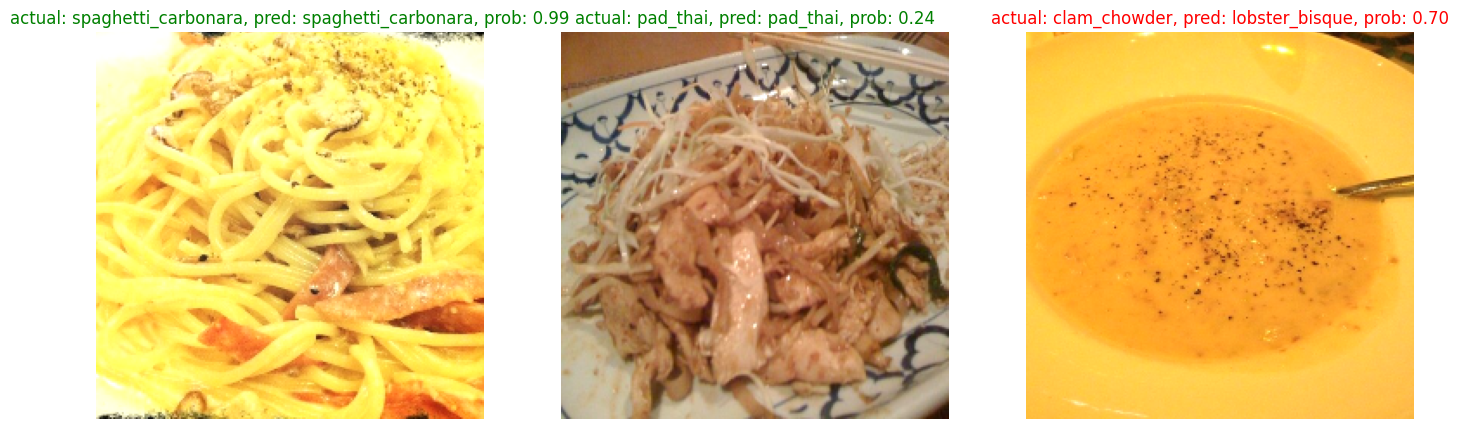

In [55]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose random image(s) from random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list
  # print(pred_prob)
  # print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  # print(img)
  plt.imshow(img/225.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

- Get all of the image file paths in the test dataset using list_files() method
- Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
- Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
- Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
- Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [56]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [57]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      85   
1      b'/content/101_food_classes_10_percent/test/ap...       0      76   
2      b'/content/101_food_classes_10_percent/test/ap...       0       8   
3      b'/content/101_food_classes_10_percent/test/ap...       0       0   
4      b'/content/101_food_classes_10_percent/test/ap...       0       2   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25247  b'/content/101_food_classes_10_percent/test/wa...     100       8   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      23   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname y_pred_classname  
0       0.376337        apple_pie           samosa  
1       0.351667        apple_pie            pizza  
2       0.365355        apple_pie    bread_pudding  
3       0.625422        apple_pie        apple_pie  
4       0.312720        apple_pie          baklava  
...          ...              ...              ...  
25245   0.982972          waffles          waffles  
25246   0.636660          waffles          waffles  
25247   0.474205          waffles    bread_pudding  
25248   0.287333          waffles          churros  
25249   0.951003          waffles          waffles  

[25250 rows x 6 columns]

In [58]:
# 3. Find out in our DataFrame which predictions are wrong and which are correct
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      85   
1  b'/content/101_food_classes_10_percent/test/ap...       0      76   
2  b'/content/101_food_classes_10_percent/test/ap...       0       8   
3  b'/content/101_food_classes_10_percent/test/ap...       0       0   
4  b'/content/101_food_classes_10_percent/test/ap...       0       2   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.376337        apple_pie           samosa         False  
1   0.351667        apple_pie            pizza         False  
2   0.365355        apple_pie    bread_pudding         False  
3   0.625422        apple_pie        apple_pie          True  
4   0.312720        apple_pie          baklava         False

In [59]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
14152  b'/content/101_food_classes_10_percent/test/hu...      56      27   
13610  b'/content/101_food_classes_10_percent/test/ho...      54      27   
14842  b'/content/101_food_classes_10_percent/test/la...      59      27   
13029  b'/content/101_food_classes_10_percent/test/gy...      52      27   
14325  b'/content/101_food_classes_10_percent/test/hu...      57      27   
24048  b'/content/101_food_classes_10_percent/test/ta...      96      11   
14409  b'/content/101_food_classes_10_percent/test/hu...      57      27   
12164  b'/content/101_food_classes_10_percent/test/gr...      48      16   
15708  b'/content/101_food_classes_10_percent/test/ma...      62      27   
15743  b'/content/101_food_classes_10_percent/test/ma...      62      27   
14290  b'/content/101_food_classes_10_percent/test/hu...      57      31   
15619  b'/content/101_food_classes_10_percent/test/ma...      62      27   
15826  b'/content/101_food_classes_10_percent/test/ma...      63      29   
12881  b'/content/101_food_classes_10_percent/test/gu...      51      57   
11249  b'/content/101_food_classes_10_percent/test/fr...      44      84   
14631  b'/content/101_food_classes_10_percent/test/ic...      58      45   
16061  b'/content/101_food_classes_10_percent/test/mi...      64      27   
2657   b'/content/101_food_classes_10_percent/test/br...      10      27   
4385   b'/content/101_food_classes_10_percent/test/ch...      17      27   
21264  b'/content/101_food_classes_10_percent/test/sa...      85       2   

       pred_conf     y_true_classname y_pred_classname  pred_correct  
14152   0.999469     huevos_rancheros     creme_brulee         False  
13610   0.999190    hot_and_sour_soup     creme_brulee         False  
14842   0.999146              lasagna     creme_brulee         False  
13029   0.998942                gyoza     creme_brulee         False  
14325   0.998933               hummus     creme_brulee         False  
24048   0.998674                tacos     caesar_salad         False  
14409   0.998672               hummus     creme_brulee         False  
12164   0.998444          greek_salad     cheese_plate         False  
15708   0.998243  macaroni_and_cheese     creme_brulee         False  
15743   0.998127  macaroni_and_cheese     creme_brulee         False  
14290   0.998021               hummus           donuts         False  
15619   0.997838  macaroni_and_cheese     creme_brulee         False  
15826   0.997575             macarons        cup_cakes         False  
12881   0.997550            guacamole           hummus         False  
11249   0.997389           fried_rice          risotto         False  
14631   0.997236            ice_cream    frozen_yogurt         False  
16061   0.997205            miso_soup     creme_brulee         False  
2657    0.997186           bruschetta     creme_brulee         False  
4385    0.997032           cheesecake     creme_brulee         False  
21264   0.996763               samosa          baklava         False

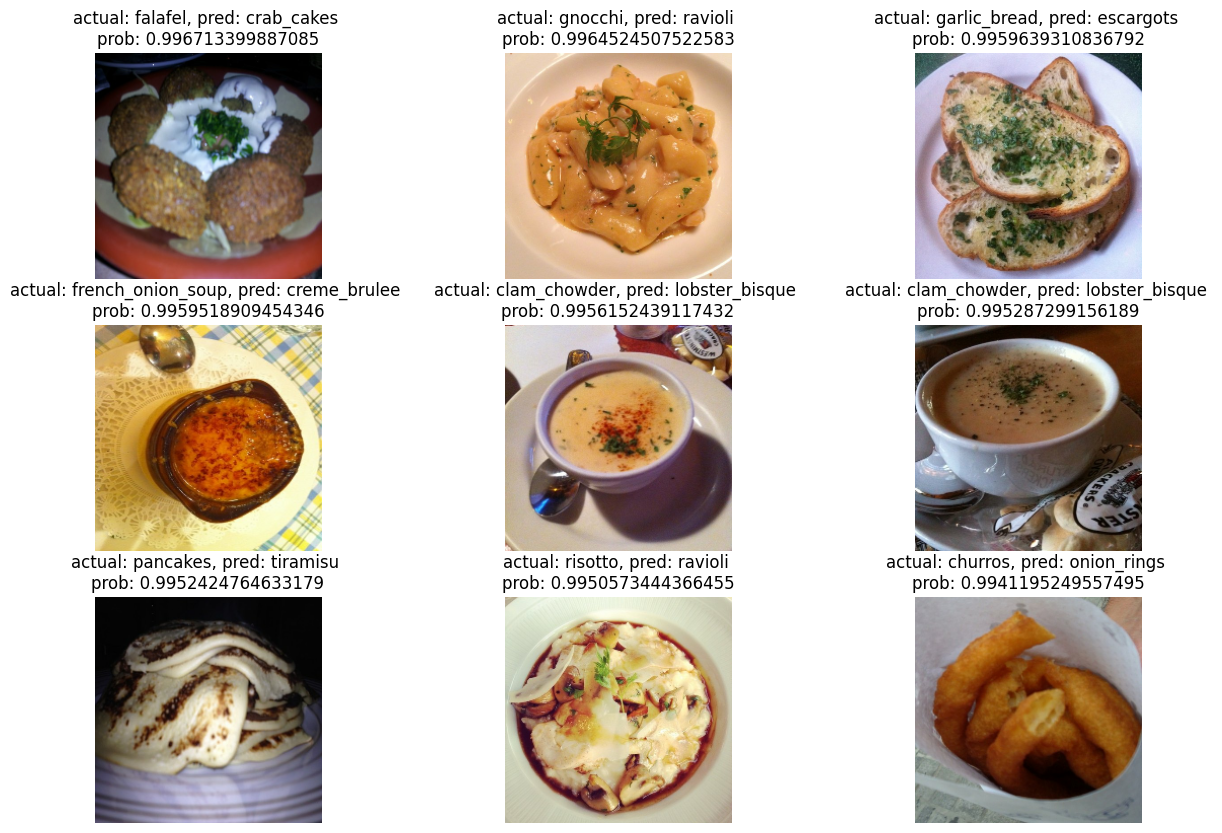

In [60]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 20
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)

## Test our Model on Custom Images

In [61]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2025-04-22 01:52:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  26.2MB/s    in 0.5s    

2025-04-22 01:52:46 (26.2 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [62]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


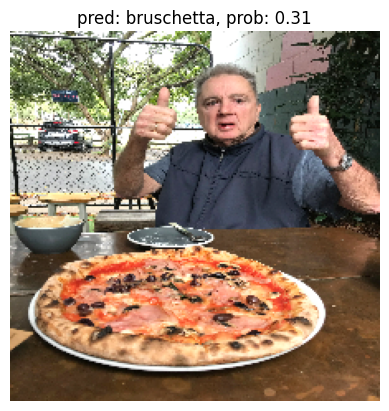

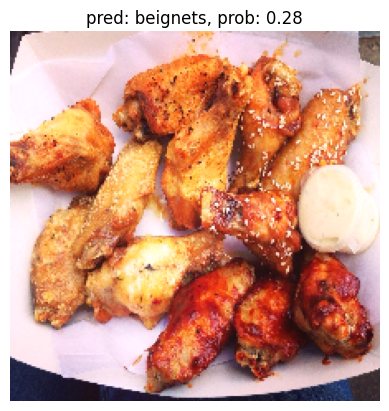

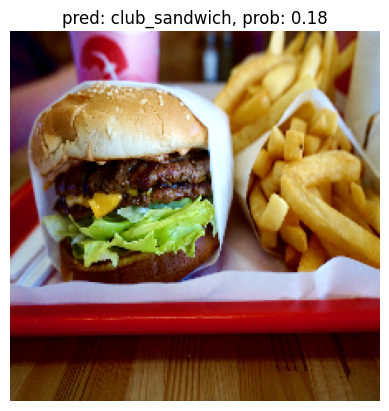

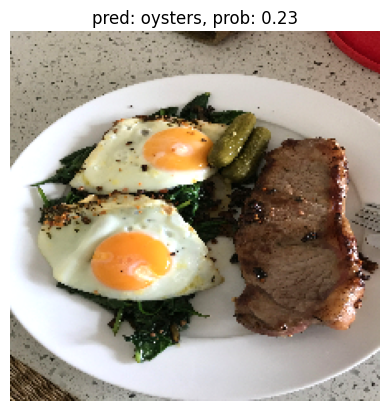

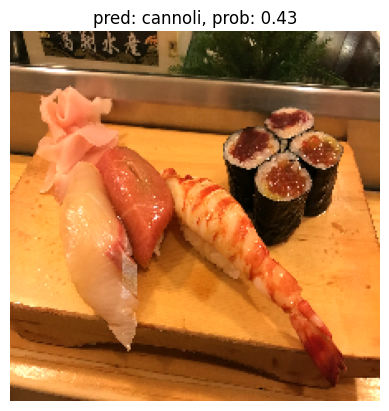

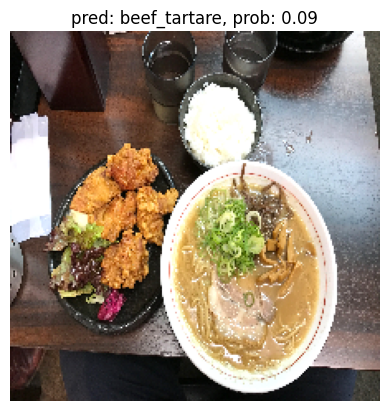

In [65]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highet prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)